In [1]:
# Load package
import numpy as np; from scipy import stats; import matplotlib.pyplot as plt; import pymc as pm;import arviz as az; 
import math; import pandas as pd
from scipy.optimize import minimize
from scipy import special
import pytensor.tensor as pt
import matplotlib.pyplot as plt

# Task 1: Profile loglik and adjusted profile loglik: 

- double-check with the formulae for the likelihood function and cod
- plot these functions and do a grid search

In [2]:
def generate_Corr_identity(p):
    Sigma = np.zeros((p-1, p-1))
    np.fill_diagonal(Sigma, 1)
    return Sigma

def generate_data(n, p, sigma_sqr, beta, nu, corr):

    beta = beta.reshape((p, 1))
    x_i = np.random.normal(0, 1, (n, p - 1))
    x_i_correlated = x_i @ corr
    ones = np.ones((n, 1))
    x_i_full =  np.concatenate((ones, x_i_correlated), axis=1)
    XB = x_i_full @ beta
    E = stats.t.rvs(df = nu, loc=0, scale= np.sqrt(sigma_sqr), size=(n, 1))
    Y = XB + E
    return Y, x_i_full

def negative_log_likelihood_optimize_beta_sigma(params, nu):
    """
    Negative log likelihood that will be passed into minimize function for given nu
    The use of it is to get the numerical result of beta and sigma
    :param params: contains beta and sigma as one vector, dim = p + 1
    :param nu: Degree of freedom
    :param X: Data matrix
    :param y: Observed Value
    :return: The negative log likelihood equation (2) in Fonseca 2008
    """

    betas, sigma = params[:-1], params[-1]
    if sigma <= 0:
        return np.inf  # Return infinity if sigma is non-positive
    p = X.shape[1]
    B = np.reshape(betas, (p, 1))
    XB = X @ B
    n = X.shape[0]
    XB = XB.reshape((n, 1))
    # loglikelihood
    equation = n * np.log(special.gamma((nu + 1)/2)) + n* nu *0.5 * np.log(nu) - n * np.log(special.gamma(nu/2)) - 0.5*n*np.log(np.pi) - n * np.log(sigma) - 0.5 *(nu + 1)*np.sum(np.log(nu + ((y - XB)/sigma)**2))
    return -equation

def optimize_over_nu(nu):
    p = X.shape[1]
    bounds = [(None, None)] * p +[(0, np.inf)]
    initial_guess = np.random.normal(0, 1, size = (p+1))
    initial_guess[p] = np.abs(initial_guess[p])
    result = minimize(negative_log_likelihood_optimize_beta_sigma, initial_guess, args=(nu,), method='Nelder-Mead',bounds= bounds)

    return result.x# Return the optimized parameters

def profile_loglikelihood(nu):
    sigma = optimize_over_nu(nu)[-1]
    beta = optimize_over_nu(nu)[0:-1]
    
    B = np.reshape(beta, (p, 1))
    XB = X @ B

    #XB = beta1*X[:, 0] + beta2*X[:, 1] + beta3*X[:, 2] + beta4*X[:, 3] + beta5*X[:, 4]
    n = X.shape[0]
    XB = XB.reshape((n, 1))

    eqt = n * np.log(special.gamma((nu + 1)/2)) + n* nu *0.5 * np.log(nu) - n * np.log(special.gamma(nu/2)) - 0.5*n*np.log(np.pi) - n * np.log(sigma) - 0.5 *(nu + 1)*np.sum(np.log(nu + ((y - XB)/sigma)**2))
    return -eqt

def Hess_beta_sigma(beta, sigma, nu, X, y):
    """
    The Hessian matrix of the log likelihood function
    :param beta: Coefficients
    :param sigma: Scale
    :param nu: Degree of freedom
    :param X: Data Matrix
    :param y: Observed Value
    :return: Hessian Matrix of beta and sigma on the log likelihood function, equation (2) Fonseca 2008
    """
    p = X.shape[1]
    n = X.shape[0]
    beta = np.array(beta)
    sigma = np.array(sigma)
    total_b2 = 0
    total_b_sigma = 0
    total_sigma_b = 0
    total_s2 = 0
    for i in range(n):
        Xi = np.reshape(X[i,:], (p, 1))
        residual = y[i] - X[i, :] @ beta
        nu_sigma_sqr_plus_residual =  nu*(sigma**2)+ residual**2
        total_b2 = total_b2 + (- (nu_sigma_sqr_plus_residual)* np.outer(X[i,:],X[i, :]) + np.outer(X[i, :], X[i, :])*2*(residual**2))/(nu_sigma_sqr_plus_residual**2)
        total_b_sigma = total_b_sigma + (- nu_sigma_sqr_plus_residual*2 * residual * X[i,:] + 2*(residual**3 )*X[i,:]) / (nu_sigma_sqr_plus_residual**2)
        total_sigma_b = total_sigma_b + (-2*nu*sigma*X[i,:]*residual)/(nu_sigma_sqr_plus_residual**2)
        total_s2 = total_s2+ (-(residual**2) * 2* nu ) / ( (nu_sigma_sqr_plus_residual**2)) - 2*(residual**2)/(nu_sigma_sqr_plus_residual* (sigma**2))

    db2 = total_b2 * (nu+1)
    dbs = total_b_sigma * (nu+1)/sigma
    dsb = total_sigma_b * (nu+1)
    ds2 = n/(sigma**2) + (nu+1)*total_s2

    hessian = np.zeros((p + 1, p + 1))
    hessian[:p, :p] = db2
    hessian[:p, p] = dbs
    hessian[p, :p] = dsb
    hessian[p, p] = ds2

    return hessian

def obs_block_det(beta, sigma, nu, X, y):
    
    block = np.array(Hess_beta_sigma(beta, sigma, nu, X, y))* -1
    
    return np.linalg.det(block)

def adj_profile_loglikelihood(nu):
    sigma = optimize_over_nu(nu)[-1]
    beta = optimize_over_nu(nu)[0:-1]
    
    B = np.reshape(beta, (p, 1))
    XB = X @ B

    #XB = beta1*X[:, 0] + beta2*X[:, 1] + beta3*X[:, 2] + beta4*X[:, 3] + beta5*X[:, 4]
    n = X.shape[0]
    XB = XB.reshape((n, 1))
    det = obs_block_det(beta, sigma, nu, X, y)

    adj_eqt = n * np.log(special.gamma((nu + 1)/2)) + n* nu *0.5 * np.log(nu) - n * np.log(special.gamma(nu/2)) - 0.5*n*np.log(np.pi) - n * np.log(sigma) - 0.5 *(nu + 1)*np.sum(np.log(nu + ((y - XB)/sigma)**2))-0.5*np.log(abs(det)) 
    return -adj_eqt

## true nu = 5, betas = [2, 1, 0.3, 0.9, 1]

In [45]:
# Generate Data
p = 5 #number of betas
beta = np.array([2, 1, 0.3, 0.9, 1])
n = 1000
nu_origin = 5
sigma_sqr = 1.5
corr = generate_Corr_identity(p)  
y, X = generate_data(n, p, sigma_sqr, beta, nu_origin, corr)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


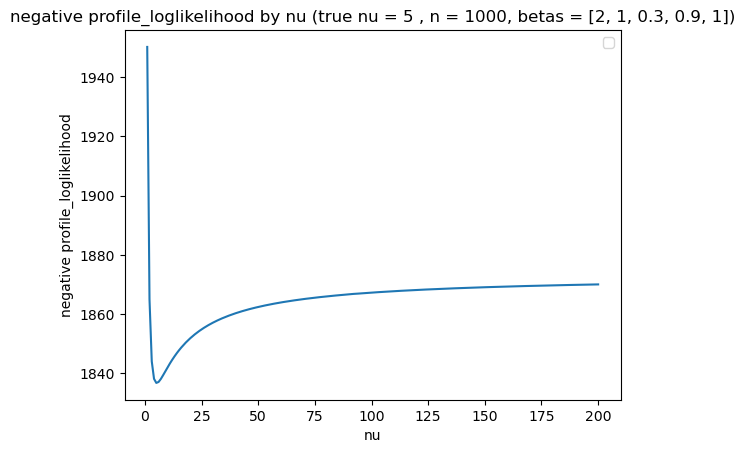

In [46]:
# Profile likelihood Grid search
nu_list =[]
profile_loglikelihood_list = []

for nu in range(1,201):
    nu_list.append(nu)
    profile_loglikelihood_list.append(profile_loglikelihood(nu))
    profile_DF = pd.DataFrame({'nu': nu_list,
                        'profile_loglikelihood': profile_loglikelihood_list,
                        })

# Plotting Profile likelihood
plt.plot(profile_DF['nu'], profile_DF['profile_loglikelihood'])
# Adding labels and legend
plt.xlabel('nu')
plt.ylabel('negative profile_loglikelihood')
plt.title('negative profile_loglikelihood by nu (true nu = 5 , n = 1000, betas = [2, 1, 0.3, 0.9, 1])')
plt.legend()
# Showing the plot
plt.show()

In [47]:
minimize(profile_loglikelihood,1,method='Nelder-Mead', bounds = [(0, np.inf)])

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 1836.7429515379567
             x: [ 5.188e+00]
           nit: 22
          nfev: 46
 final_simplex: (array([[ 5.188e+00],
                       [ 5.188e+00]]), array([ 1.837e+03,  1.837e+03]))

In [49]:
np.argmin(profile_DF['profile_loglikelihood']) + 1

5

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


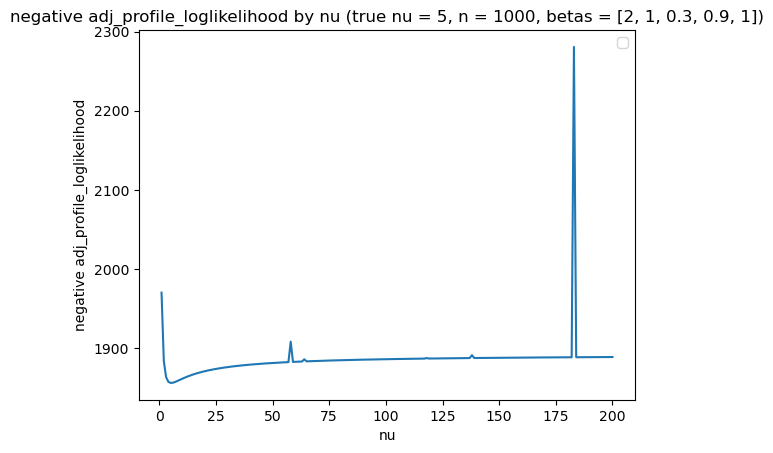

In [50]:
# Adj Profile likelihood Grid search
nu_list =[]
adj_profile_loglikelihood_list = []

for nu in range(1,201):
    nu_list.append(nu)
    adj_profile_loglikelihood_list.append(adj_profile_loglikelihood(nu))
    adj_DF = pd.DataFrame({'nu': nu_list,
                        'adj_profile_loglikelihood': adj_profile_loglikelihood_list,
                        })
    
# Adj Profile likelihood Plotting
plt.plot(adj_DF['nu'], adj_DF['adj_profile_loglikelihood'])
# Adding labels and legend
plt.xlabel('nu')
plt.ylabel('negative adj_profile_loglikelihood')
plt.title('negative adj_profile_loglikelihood by nu (true nu = 5, n = 1000, betas = [2, 1, 0.3, 0.9, 1])')
plt.legend()
# Showing the plot
plt.show()

In [51]:
minimize(adj_profile_loglikelihood,1,method='Nelder-Mead', bounds = [(0, np.inf)])

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 1855.8059078616043
             x: [ 5.225e+00]
           nit: 35
          nfev: 82
 final_simplex: (array([[ 5.225e+00],
                       [ 5.225e+00]]), array([ 1.856e+03,  1.856e+03]))

In [53]:
np.argmin(adj_DF['adj_profile_loglikelihood']) + 1

5

## true nu = 100, betas = [2, 1, 0.3, 0.9, 1]

In [54]:
# Generate Data
p = 5 #number of betas
beta = np.array([2, 1, 0.3, 0.9, 1])
n = 1000
nu_origin = 100
sigma_sqr = 1.5
corr = generate_Corr_identity(p)  
y, X = generate_data(n, p, sigma_sqr, beta, nu_origin, corr)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


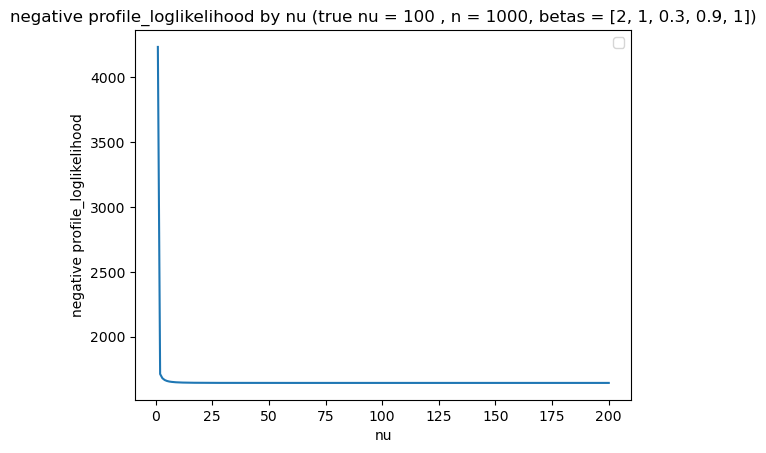

In [55]:
# Profile likelihood Grid search
nu_list =[]
profile_loglikelihood_list = []

for nu in range(1,201):
    nu_list.append(nu)
    profile_loglikelihood_list.append(profile_loglikelihood(nu))
    profile_DF = pd.DataFrame({'nu': nu_list,
                        'profile_loglikelihood': profile_loglikelihood_list,
                        })

# Plotting Profile likelihood
plt.plot(profile_DF['nu'], profile_DF['profile_loglikelihood'])
# Adding labels and legend
plt.xlabel('nu')
plt.ylabel('negative profile_loglikelihood')
plt.title('negative profile_loglikelihood by nu (true nu = 100 , n = 1000, betas = [2, 1, 0.3, 0.9, 1])')
plt.legend()
# Showing the plot
plt.show()

In [56]:
minimize(profile_loglikelihood,1,method='Nelder-Mead', bounds = [(0, np.inf)])

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 1643.8725802383851
             x: [ 7.773e+01]
           nit: 30
          nfev: 68
 final_simplex: (array([[ 7.773e+01],
                       [ 7.773e+01]]), array([ 1.644e+03,  1.644e+03]))

In [57]:
np.argmin(profile_DF['profile_loglikelihood']) + 1

77

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


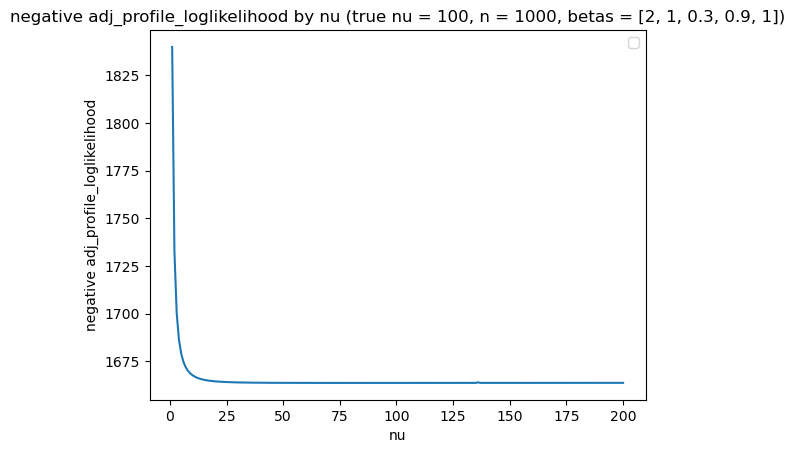

In [58]:
# Adj Profile likelihood Grid search
nu_list =[]
adj_profile_loglikelihood_list = []

for nu in range(1,201):
    nu_list.append(nu)
    adj_profile_loglikelihood_list.append(adj_profile_loglikelihood(nu))
    adj_DF = pd.DataFrame({'nu': nu_list,
                        'adj_profile_loglikelihood': adj_profile_loglikelihood_list,
                        })
    
# Adj Profile likelihood Plotting
plt.plot(adj_DF['nu'], adj_DF['adj_profile_loglikelihood'])
# Adding labels and legend
plt.xlabel('nu')
plt.ylabel('negative adj_profile_loglikelihood')
plt.title('negative adj_profile_loglikelihood by nu (true nu = 100, n = 1000, betas = [2, 1, 0.3, 0.9, 1])')
plt.legend()
# Showing the plot
plt.show()

In [59]:
minimize(adj_profile_loglikelihood,1,method='Nelder-Mead', bounds = [(0, np.inf)])

       message: Maximum number of function evaluations has been exceeded.
       success: False
        status: 1
           fun: 1663.769201525224
             x: [ 7.927e+01]
           nit: 76
          nfev: 200
 final_simplex: (array([[ 7.927e+01],
                       [ 7.927e+01]]), array([ 1.664e+03,  1.664e+03]))

In [60]:
np.argmin(adj_DF['adj_profile_loglikelihood']) + 1

76

## true nu = 5, betas = [20, 10, 30, 90, 15]

In [61]:
# Generate Data
p = 5 #number of betas
beta = np.array([20, 10, 30, 90, 15])
n = 1000
nu_origin = 5
sigma_sqr = 1.5
corr = generate_Corr_identity(p)  
y, X = generate_data(n, p, sigma_sqr, beta, nu_origin, corr)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


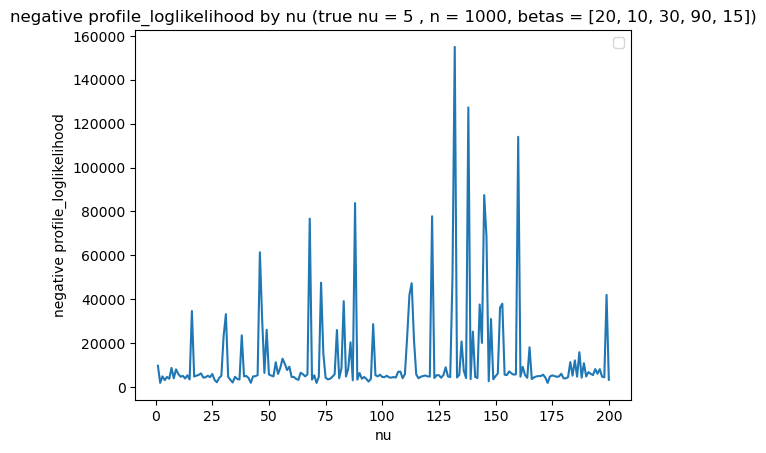

In [62]:
# Profile likelihood Grid search
nu_list =[]
profile_loglikelihood_list = []

for nu in range(1,201):
    nu_list.append(nu)
    profile_loglikelihood_list.append(profile_loglikelihood(nu))
    profile_DF = pd.DataFrame({'nu': nu_list,
                        'profile_loglikelihood': profile_loglikelihood_list,
                        })

# Plotting Profile likelihood
plt.plot(profile_DF['nu'], profile_DF['profile_loglikelihood'])
# Adding labels and legend
plt.xlabel('nu')
plt.ylabel('negative profile_loglikelihood')
plt.title('negative profile_loglikelihood by nu (true nu = 5 , n = 1000, betas = [20, 10, 30, 90, 15])')
plt.legend()
# Showing the plot
plt.show()

In [63]:
minimize(profile_loglikelihood,1,method='Nelder-Mead', bounds = [(0, np.inf)])

       message: Maximum number of function evaluations has been exceeded.
       success: False
        status: 1
           fun: 1962.545365967636
             x: [ 9.750e-01]
           nit: 74
          nfev: 200
 final_simplex: (array([[ 9.750e-01],
                       [ 9.750e-01]]), array([ 1.963e+03,  4.217e+03]))

In [64]:
np.argmin(profile_DF['profile_loglikelihood']) + 1

2

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


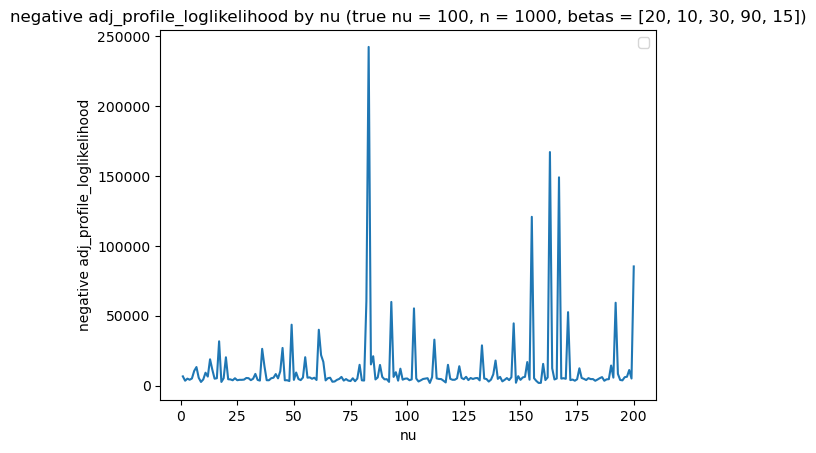

In [65]:
# Adj Profile likelihood Grid search
nu_list =[]
adj_profile_loglikelihood_list = []

for nu in range(1,201):
    nu_list.append(nu)
    adj_profile_loglikelihood_list.append(adj_profile_loglikelihood(nu))
    adj_DF = pd.DataFrame({'nu': nu_list,
                        'adj_profile_loglikelihood': adj_profile_loglikelihood_list,
                        })
    
# Adj Profile likelihood Plotting
plt.plot(adj_DF['nu'], adj_DF['adj_profile_loglikelihood'])
# Adding labels and legend
plt.xlabel('nu')
plt.ylabel('negative adj_profile_loglikelihood')
plt.title('negative adj_profile_loglikelihood by nu (true nu = 100, n = 1000, betas = [20, 10, 30, 90, 15])')
plt.legend()
# Showing the plot
plt.show()

In [66]:
minimize(adj_profile_loglikelihood,1,method='Nelder-Mead', bounds = [(0, np.inf)])

       message: Maximum number of function evaluations has been exceeded.
       success: False
        status: 1
           fun: 1962.4426932797367
             x: [ 1.094e+00]
           nit: 73
          nfev: 200
 final_simplex: (array([[ 1.094e+00],
                       [ 1.094e+00]]), array([ 1.962e+03,  2.012e+03]))

In [67]:
np.argmin(adj_DF['adj_profile_loglikelihood']) + 1

110

## true nu = 100, betas = [20, 10, 30, 90, 15]

In [68]:
# Generate Data
p = 5 #number of betas
beta = np.array([20, 10, 30, 90, 15])
n = 1000
nu_origin = 100
sigma_sqr = 1.5
corr = generate_Corr_identity(p)  
y, X = generate_data(n, p, sigma_sqr, beta, nu_origin, corr)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


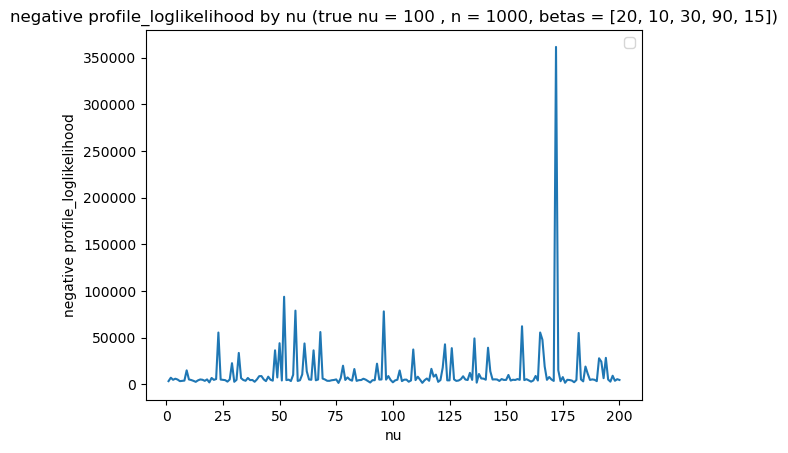

In [69]:
# Profile likelihood Grid search
nu_list =[]
profile_loglikelihood_list = []

for nu in range(1,201):
    nu_list.append(nu)
    profile_loglikelihood_list.append(profile_loglikelihood(nu))
    profile_DF = pd.DataFrame({'nu': nu_list,
                        'profile_loglikelihood': profile_loglikelihood_list,
                        })

# Plotting Profile likelihood
plt.plot(profile_DF['nu'], profile_DF['profile_loglikelihood'])
# Adding labels and legend
plt.xlabel('nu')
plt.ylabel('negative profile_loglikelihood')
plt.title('negative profile_loglikelihood by nu (true nu = 100 , n = 1000, betas = [20, 10, 30, 90, 15])')
plt.legend()
# Showing the plot
plt.show()

In [70]:
minimize(profile_loglikelihood,1,method='Nelder-Mead', bounds = [(0, np.inf)])

       message: Maximum number of function evaluations has been exceeded.
       success: False
        status: 1
           fun: 1787.2611360670994
             x: [ 1.123e+00]
           nit: 75
          nfev: 200
 final_simplex: (array([[ 1.123e+00],
                       [ 1.123e+00]]), array([ 1.787e+03,  5.265e+03]))

In [71]:
np.argmin(profile_DF['profile_loglikelihood']) + 1

76

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


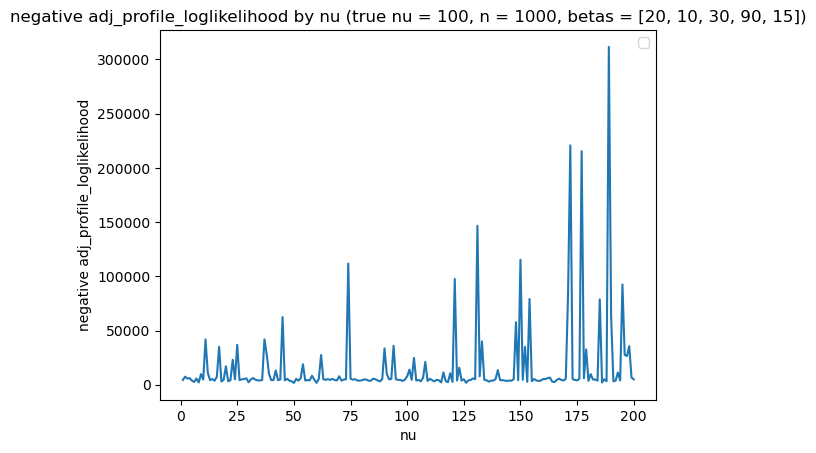

In [72]:
# Adj Profile likelihood Grid search
nu_list =[]
adj_profile_loglikelihood_list = []

for nu in range(1,201):
    nu_list.append(nu)
    adj_profile_loglikelihood_list.append(adj_profile_loglikelihood(nu))
    adj_DF = pd.DataFrame({'nu': nu_list,
                        'adj_profile_loglikelihood': adj_profile_loglikelihood_list,
                        })
    
# Adj Profile likelihood Plotting
plt.plot(adj_DF['nu'], adj_DF['adj_profile_loglikelihood'])
# Adding labels and legend
plt.xlabel('nu')
plt.ylabel('negative adj_profile_loglikelihood')
plt.title('negative adj_profile_loglikelihood by nu (true nu = 100, n = 1000, betas = [20, 10, 30, 90, 15])')
plt.legend()
# Showing the plot
plt.show()

In [73]:
minimize(adj_profile_loglikelihood,1,method='Nelder-Mead', bounds = [(0, np.inf)])

       message: Maximum number of function evaluations has been exceeded.
       success: False
        status: 1
           fun: 1834.9684660692046
             x: [ 9.500e-01]
           nit: 74
          nfev: 200
 final_simplex: (array([[ 9.500e-01],
                       [ 9.500e-01]]), array([ 1.835e+03,  4.683e+03]))

In [74]:
np.argmin(adj_DF['adj_profile_loglikelihood']) + 1

50

## MSE plots by optimization 

In [107]:
def calculate_y_axix(nu_origin, nu_est):
    n = len(nu_est)
    nu_origin_vec = nu_origin * np.ones((n, 1))
    mse = np.sum((nu_est - nu_origin_vec)**2) / n
    result = np.sqrt(mse)/nu_origin
    return result

In [21]:
# Fix number of observations
n = 100

result_value_mse_profile = []
result_value_mse_adj_profile =[] 
nu_list = []

for nu_origin in range(1,11): # loop true nu 
    nu_list.append(nu_origin)
    mle_profile =[]
    mle_adj_profile =[]

    for j in range(10): # number of simulations
        p = 5
        beta = np.array([2, 1, 0.3, 0.9, 1]) #stats.norm.rvs(size=p)
        sigma_sqr = 1.5
        corr = generate_Corr_identity(p)  
        y, X = generate_data(n, p, sigma_sqr, beta, nu_origin, corr) ## Generate data)
        
        # profile likelihood MLE
        profile_result = minimize(profile_loglikelihood,nu_origin,method='Nelder-Mead', bounds = [(0, np.inf)])
        if profile_result.success == False:
            print("profile error: " + 'true nu = '+str(nu_origin) +' at ' + str(j + 1) + 'th simulation')
        else:
            mle_profile.append(profile_result.x)
        
        # adjusted profile likelihood MLE
        adj_profile_result = minimize(adj_profile_loglikelihood,nu_origin,method='Nelder-Mead', bounds = [(0, np.inf)])
        if adj_profile_result.success == False:
            print("adj profile error: "+ 'true nu = '+str(nu_origin) +' at ' + str(j + 1) + 'th simulation')
        else:
            mle_adj_profile.append(adj_profile_result.x)        


    # record averaged MSE 
    value_mse_profile = calculate_y_axix(nu_origin, mle_profile)
    result_value_mse_profile.append(value_mse_profile) 
    
    value_mse_adj_profile = calculate_y_axix(nu_origin, mle_adj_profile)
    result_value_mse_adj_profile.append(value_mse_adj_profile)     
    

df = pd.DataFrame({'nu': nu_list,
                    'MSE profile likellihood': result_value_mse_profile,
                   'MSE adj profile likellihood': result_value_mse_adj_profile
                   
                        })

adj profile error: true nu = 1 at 8th simulation
adj profile error: true nu = 2 at 3th simulation
adj profile error: true nu = 3 at 1th simulation
adj profile error: true nu = 3 at 2th simulation
adj profile error: true nu = 3 at 4th simulation
adj profile error: true nu = 3 at 6th simulation
adj profile error: true nu = 3 at 7th simulation
adj profile error: true nu = 3 at 9th simulation
adj profile error: true nu = 3 at 10th simulation
adj profile error: true nu = 4 at 6th simulation
adj profile error: true nu = 4 at 7th simulation
adj profile error: true nu = 4 at 10th simulation
adj profile error: true nu = 5 at 1th simulation
adj profile error: true nu = 5 at 2th simulation
adj profile error: true nu = 5 at 5th simulation
adj profile error: true nu = 5 at 8th simulation
adj profile error: true nu = 6 at 1th simulation
adj profile error: true nu = 6 at 2th simulation


/tmp/ipykernel_53/919142380.py:38: RuntimeWarning: divide by zero encountered in log
  equation = n * np.log(special.gamma((nu + 1)/2)) + n* nu *0.5 * np.log(nu) - n * np.log(special.gamma(nu/2)) - 0.5*n*np.log(np.pi) - n * np.log(sigma) - 0.5 *(nu + 1)*np.sum(np.log(nu + ((y - XB)/sigma)**2))
/tmp/ipykernel_53/919142380.py:38: RuntimeWarning: invalid value encountered in multiply
  equation = n * np.log(special.gamma((nu + 1)/2)) + n* nu *0.5 * np.log(nu) - n * np.log(special.gamma(nu/2)) - 0.5*n*np.log(np.pi) - n * np.log(sigma) - 0.5 *(nu + 1)*np.sum(np.log(nu + ((y - XB)/sigma)**2))
/tmp/ipykernel_53/919142380.py:66: RuntimeWarning: divide by zero encountered in log
  eqt = n * np.log(special.gamma((nu + 1)/2)) + n* nu *0.5 * np.log(nu) - n * np.log(special.gamma(nu/2)) - 0.5*n*np.log(np.pi) - n * np.log(sigma) - 0.5 *(nu + 1)*np.sum(np.log(nu + ((y - XB)/sigma)**2))
/tmp/ipykernel_53/919142380.py:66: RuntimeWarning: invalid value encountered in multiply
  eqt = n * np.log(special.

adj profile error: true nu = 6 at 5th simulation


/tmp/ipykernel_53/919142380.py:38: RuntimeWarning: invalid value encountered in subtract
  equation = n * np.log(special.gamma((nu + 1)/2)) + n* nu *0.5 * np.log(nu) - n * np.log(special.gamma(nu/2)) - 0.5*n*np.log(np.pi) - n * np.log(sigma) - 0.5 *(nu + 1)*np.sum(np.log(nu + ((y - XB)/sigma)**2))
/tmp/ipykernel_53/919142380.py:66: RuntimeWarning: invalid value encountered in subtract
  eqt = n * np.log(special.gamma((nu + 1)/2)) + n* nu *0.5 * np.log(nu) - n * np.log(special.gamma(nu/2)) - 0.5*n*np.log(np.pi) - n * np.log(sigma) - 0.5 *(nu + 1)*np.sum(np.log(nu + ((y - XB)/sigma)**2))
/opt/conda/lib/python3.11/site-packages/scipy/optimize/_optimize.py:917: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


profile error: true nu = 6 at 7th simulation


/tmp/ipykernel_53/919142380.py:132: RuntimeWarning: invalid value encountered in subtract
  adj_eqt = n * np.log(special.gamma((nu + 1)/2)) + n* nu *0.5 * np.log(nu) - n * np.log(special.gamma(nu/2)) - 0.5*n*np.log(np.pi) - n * np.log(sigma) - 0.5 *(nu + 1)*np.sum(np.log(nu + ((y - XB)/sigma)**2))-0.5*np.log(abs(det))


adj profile error: true nu = 7 at 2th simulation
profile error: true nu = 7 at 9th simulation
profile error: true nu = 7 at 10th simulation
adj profile error: true nu = 7 at 10th simulation
profile error: true nu = 8 at 2th simulation
adj profile error: true nu = 8 at 2th simulation
profile error: true nu = 8 at 3th simulation
profile error: true nu = 8 at 5th simulation
adj profile error: true nu = 8 at 5th simulation
profile error: true nu = 8 at 7th simulation
adj profile error: true nu = 8 at 8th simulation
profile error: true nu = 8 at 9th simulation
adj profile error: true nu = 9 at 1th simulation
adj profile error: true nu = 9 at 2th simulation
adj profile error: true nu = 9 at 5th simulation
adj profile error: true nu = 9 at 10th simulation
profile error: true nu = 10 at 2th simulation
adj profile error: true nu = 10 at 2th simulation
profile error: true nu = 10 at 3th simulation
adj profile error: true nu = 10 at 3th simulation
profile error: true nu = 10 at 5th simulation
adj

In [22]:
df

,nu,MSE profile likellihood,MSE adj profile likellihood
0,1,0.270227,0.383929
1,2,0.537412,0.659043
2,3,0.395968,0.203487
3,4,0.294413,0.310284
4,5,0.538059,0.817406
5,6,2.294774,21.635613
6,7,0.416108,15.916699
7,8,1.187262,27.072884
8,9,1.089116,1.358857
9,10,0.359195,13.466094


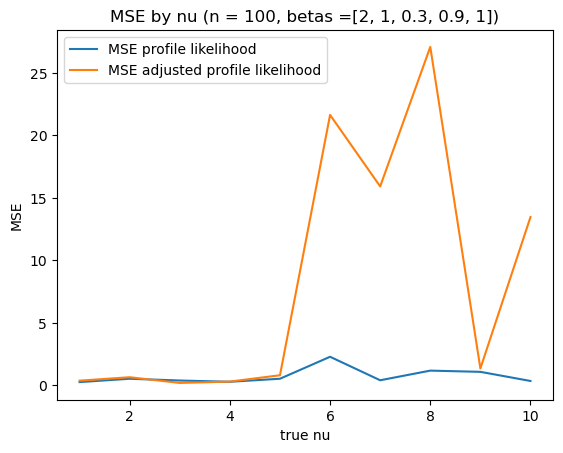

In [25]:
# Plot profile MSE vs nu 

# Plotting
plt.plot(df['nu'], df['MSE profile likellihood'], label='MSE profile likelihood')
plt.plot(df['nu'], df['MSE adj profile likellihood'], label='MSE adjusted profile likelihood')
# Adding labels and legend
plt.xlabel('true nu')
plt.ylabel('MSE')
plt.title('MSE by nu (n = 100, betas =[2, 1, 0.3, 0.9, 1])') #~ N(0,1)
plt.legend()
# Showing the plot
plt.show()

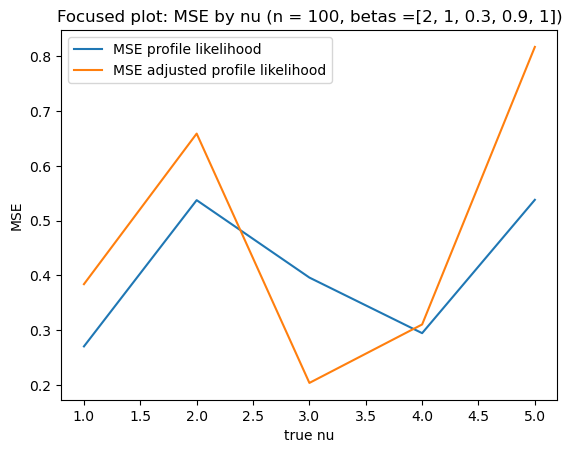

In [26]:
# Plot profile MSE vs nu 

# Plotting
plt.plot(df['nu'][0:5], df['MSE profile likellihood'][0:5], label='MSE profile likelihood')
plt.plot(df['nu'][0:5], df['MSE adj profile likellihood'][0:5], label='MSE adjusted profile likelihood')
# Adding labels and legend
plt.xlabel('true nu')
plt.ylabel('MSE')
plt.title('Focused plot: MSE by nu (n = 100, betas =[2, 1, 0.3, 0.9, 1])') #~ N(0,1)
plt.legend()
# Showing the plot
plt.show()

## MSE plot (grid search)

In [5]:
def calculate_y_axix(nu_origin, nu_est):
    n = len(nu_est)
    nu_origin_vec = nu_origin * np.ones((n, 1))
    mse = np.sum((nu_est - nu_origin_vec)**2) / n
    result = np.sqrt(mse)/nu_origin
    return result

In [91]:
# Fix number of observations
n = 100

result_value_mse_profile = []
result_value_mse_adj_profile =[] 
nu_list = []

for nu_origin in range(1,11): # loop true nu 
    nu_list.append(nu_origin)
    mle_profile =[]
    mle_adj_profile =[]

    for j in range(10): # number of simulations
        p = 5
        beta = np.array([2, 1, 0.3, 0.9, 1]) #stats.norm.rvs(size=p)
        sigma_sqr = 1.5
        corr = generate_Corr_identity(p)  
        y, X = generate_data(n, p, sigma_sqr, beta, nu_origin, corr) ## Generate data)
        
        # grid search MLE
        profile_loglikelihood_list = []
        adj_profile_loglikelihood_list = []

        for nu in range(1,21):
            # profile
            profile_loglikelihood_list.append(profile_loglikelihood(nu))
            profile_DF = pd.DataFrame({'profile_loglikelihood': profile_loglikelihood_list})
            #adj profile
            adj_profile_loglikelihood_list.append(adj_profile_loglikelihood(nu))
            adj_DF = pd.DataFrame({'adj_profile_loglikelihood': adj_profile_loglikelihood_list})
        
        # profile MAP for one simulation
        profile_result = np.argmin(profile_DF['profile_loglikelihood']) + 1
        mle_profile.append(profile_result)
        # adj profile MAP for one simulation
        adj_profile_result = np.argmin(adj_DF['adj_profile_loglikelihood']) + 1
        mle_adj_profile.append(adj_profile_result)

    # record averaged MSE 
    value_mse_profile = calculate_y_axix(nu_origin, mle_profile)
    result_value_mse_profile.append(value_mse_profile) 
    
    value_mse_adj_profile = calculate_y_axix(nu_origin, mle_adj_profile)
    result_value_mse_adj_profile.append(value_mse_adj_profile)     
    

df = pd.DataFrame({'nu': nu_list,
                    'MSE profile likellihood': result_value_mse_profile,
                   'MSE adj profile likellihood': result_value_mse_adj_profile
                   
                        })

In [92]:
df

,nu,MSE profile likellihood,MSE adj profile likellihood
0,1,1.000000,1.414214
1,2,1.732051,2.397916
2,3,0.942809,1.527525
3,4,1.936492,2.165064
4,5,4.943683,5.411100
5,6,4.149967,4.196559
6,7,3.920121,4.186957
7,8,3.466356,3.459588
8,9,2.322727,2.383068
9,10,2.439262,2.511971


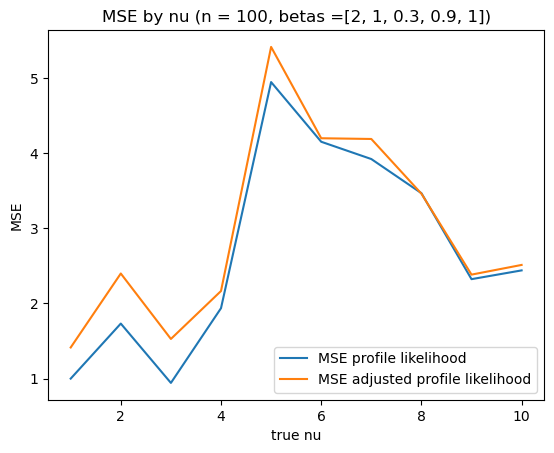

In [93]:
# Plot profile MSE vs nu 

# Plotting
plt.plot(df['nu'], df['MSE profile likellihood'], label='MSE profile likelihood')
plt.plot(df['nu'], df['MSE adj profile likellihood'], label='MSE adjusted profile likelihood')
# Adding labels and legend
plt.xlabel('true nu')
plt.ylabel('MSE')
plt.title('MSE by nu (n = 100, betas =[2, 1, 0.3, 0.9, 1])') #~ N(0,1)
plt.legend()
# Showing the plot
plt.show()

# Task 2: try to come up with a solution to the pymc() function to generate MCMC samples with Jeffreys prior and (adj) profile loglik

- don’t really need MCMC if we only want to find MAP; can try to maximize the posterior (equivalently maximize the prior*likelihood)

In [108]:
# Jeffrey's prior
def logJeff(x):
    return np.log((x/(x+3))**(1/2)*(special.polygamma(1,x/2) - special.polygamma(1, (x+1)/2) - 2*(x+3)/(x*(x+1)**2))**(1/2))

def negative_log_profile_joint(nu):
    return -logJeff(nu) + profile_loglikelihood(nu)

def negative_log_adj_joint(nu):
    return -logJeff(nu) + adj_profile_loglikelihood(nu)

## true nu = 5, betas = [2, 1, 0.3, 0.9, 1]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


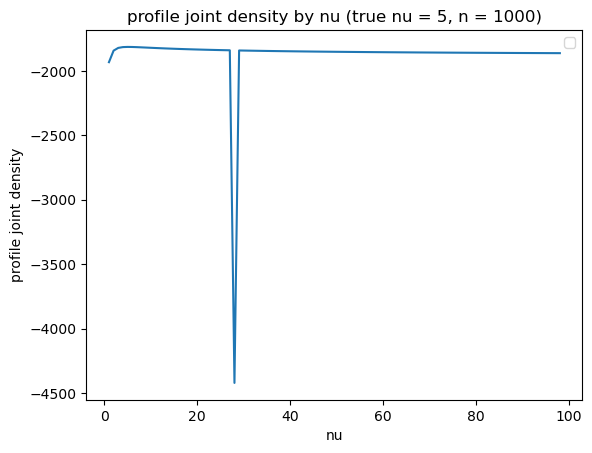

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 1814.3778659349168
             x: [ 5.092e+00]
           nit: 16
          nfev: 35
 final_simplex: (array([[ 5.092e+00],
                       [ 5.092e+00]]), array([ 1.814e+03,  1.814e+03]))

In [37]:
# Generate Data
p = 5
beta = np.array([2, 1, 0.3, 0.9, 1])
n = 1000
nu_origin = 5
sigma_sqr = 1.5
corr = generate_Corr_identity(p)  # You need to define this function
y, X = generate_data(n, p, sigma_sqr, beta, nu_origin, corr)

# Profile posterior Grid search
nu_list =[]
profile_post_list = []

for nu in range(1,99):
    nu_list.append(nu)
    profile_post_list.append(logJeff(nu) - profile_loglikelihood(nu)) # Note: profile_loglikelihood returns negative eqt
    profile_post_df = pd.DataFrame({'nu': nu_list,
                        'profile_post_list': profile_post_list,
                        })
    
# Profile posterior Plotting
plt.plot(profile_post_df['nu'], profile_post_df['profile_post_list'])
# Adding labels and legend
plt.xlabel('nu')
plt.ylabel('profile joint density')
plt.title('profile joint density by nu (true nu = 5, n = 1000)')
plt.legend()
# Showing the plot
plt.show()

# MAP grid search
print(np.argmax(profile_post_df['profile_post_list'])+1)

# MAP optimized
minimize(negative_log_profile_joint,nu_origin,method='Nelder-Mead', bounds = [(0, np.inf)])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


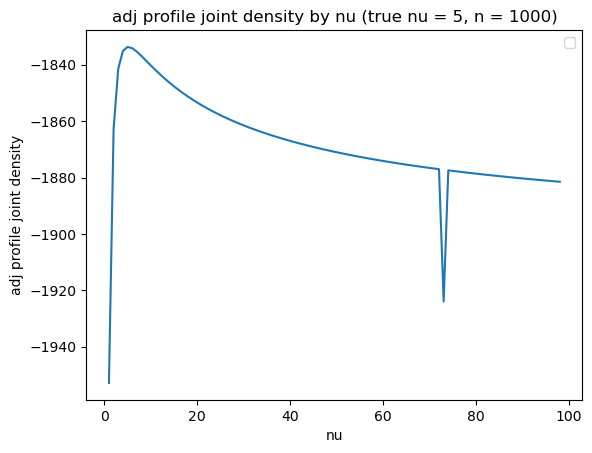

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 1833.6503055832115
             x: [ 5.133e+00]
           nit: 21
          nfev: 52
 final_simplex: (array([[ 5.133e+00],
                       [ 5.133e+00]]), array([ 1.834e+03,  1.834e+03]))

In [38]:
# Profile posterior Grid search
nu_list =[]
adj_profile_post_list = []

for nu in range(1,99):
    nu_list.append(nu)
    adj_profile_post_list.append(logJeff(nu) - adj_profile_loglikelihood(nu)) # Note: profile_loglikelihood returns negative eqt
    adj_profile_post_df = pd.DataFrame({'nu': nu_list,
                        'adj_profile_loglikelihood': adj_profile_post_list,
                        })
    
# Profile posterior Plotting
plt.plot(adj_profile_post_df['nu'], adj_profile_post_df['adj_profile_loglikelihood'])
# Adding labels and legend
plt.xlabel('nu')
plt.ylabel('adj profile joint density')
plt.title('adj profile joint density by nu (true nu = 5, n = 1000)')
plt.legend()
# Showing the plot
plt.show()

# adj MAP grid search
print(np.argmax(adj_profile_post_df['adj_profile_loglikelihood'])+1)

# adj MAP optimized
minimize(negative_log_adj_joint,nu_origin,method='Nelder-Mead', bounds = [(0, np.inf)])

## true nu = 100, betas = [2, 1, 0.3, 0.9, 1]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


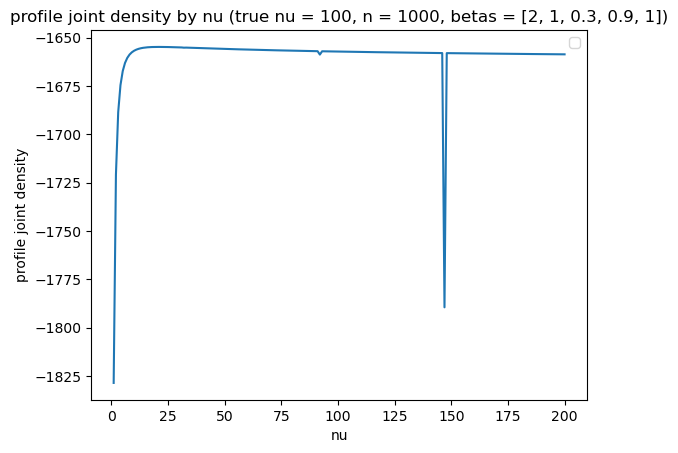

21


/tmp/ipykernel_53/541403973.py:3: RuntimeWarning: divide by zero encountered in divide
  return np.log((x/(x+3))**(1/2)*(special.polygamma(1,x/2) - special.polygamma(1, (x+1)/2) - 2*(x+3)/(x*(x+1)**2))**(1/2))
/tmp/ipykernel_53/541403973.py:3: RuntimeWarning: invalid value encountered in subtract
  return np.log((x/(x+3))**(1/2)*(special.polygamma(1,x/2) - special.polygamma(1, (x+1)/2) - 2*(x+3)/(x*(x+1)**2))**(1/2))
/tmp/ipykernel_53/919142380.py:38: RuntimeWarning: divide by zero encountered in log
  equation = n * np.log(special.gamma((nu + 1)/2)) + n* nu *0.5 * np.log(nu) - n * np.log(special.gamma(nu/2)) - 0.5*n*np.log(np.pi) - n * np.log(sigma) - 0.5 *(nu + 1)*np.sum(np.log(nu + ((y - XB)/sigma)**2))
/tmp/ipykernel_53/919142380.py:38: RuntimeWarning: invalid value encountered in multiply
  equation = n * np.log(special.gamma((nu + 1)/2)) + n* nu *0.5 * np.log(nu) - n * np.log(special.gamma(nu/2)) - 0.5*n*np.log(np.pi) - n * np.log(sigma) - 0.5 *(nu + 1)*np.sum(np.log(nu + ((y - X

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 1654.8238704889784
             x: [ 2.088e+01]
           nit: 24
          nfev: 53
 final_simplex: (array([[ 2.088e+01],
                       [ 2.088e+01]]), array([ 1.655e+03,  1.655e+03]))

In [41]:
# Generate Data
p = 5
beta = np.array([2, 1, 0.3, 0.9, 1])
n = 1000
nu_origin = 100
sigma_sqr = 1.5
corr = generate_Corr_identity(p)  # You need to define this function
y, X = generate_data(n, p, sigma_sqr, beta, nu_origin, corr)

# Profile posterior Grid search
nu_list =[]
profile_post_list = []

for nu in range(1,201):
    nu_list.append(nu)
    profile_post_list.append(logJeff(nu) - profile_loglikelihood(nu)) # Note: profile_loglikelihood returns negative eqt
    profile_post_df = pd.DataFrame({'nu': nu_list,
                        'profile_post_list': profile_post_list,
                        })
    
# Profile posterior Plotting
plt.plot(profile_post_df['nu'], profile_post_df['profile_post_list'])
# Adding labels and legend
plt.xlabel('nu')
plt.ylabel('profile joint density')
plt.title('profile joint density by nu (true nu = 100, n = 1000, betas = [2, 1, 0.3, 0.9, 1])')
plt.legend()
# Showing the plot
plt.show()

# MAP grid search
print(np.argmax(profile_post_df['profile_post_list'])+1)

# MAP optimized
minimize(negative_log_profile_joint,nu_origin,method='Nelder-Mead', bounds = [(0, np.inf)])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


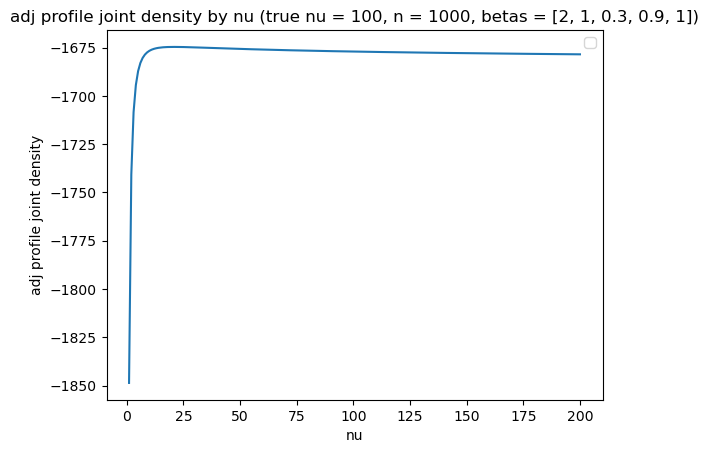

21


/tmp/ipykernel_53/541403973.py:3: RuntimeWarning: divide by zero encountered in divide
  return np.log((x/(x+3))**(1/2)*(special.polygamma(1,x/2) - special.polygamma(1, (x+1)/2) - 2*(x+3)/(x*(x+1)**2))**(1/2))
/tmp/ipykernel_53/541403973.py:3: RuntimeWarning: invalid value encountered in subtract
  return np.log((x/(x+3))**(1/2)*(special.polygamma(1,x/2) - special.polygamma(1, (x+1)/2) - 2*(x+3)/(x*(x+1)**2))**(1/2))
/tmp/ipykernel_53/919142380.py:38: RuntimeWarning: divide by zero encountered in log
  equation = n * np.log(special.gamma((nu + 1)/2)) + n* nu *0.5 * np.log(nu) - n * np.log(special.gamma(nu/2)) - 0.5*n*np.log(np.pi) - n * np.log(sigma) - 0.5 *(nu + 1)*np.sum(np.log(nu + ((y - XB)/sigma)**2))
/tmp/ipykernel_53/919142380.py:38: RuntimeWarning: invalid value encountered in multiply
  equation = n * np.log(special.gamma((nu + 1)/2)) + n* nu *0.5 * np.log(nu) - n * np.log(special.gamma(nu/2)) - 0.5*n*np.log(np.pi) - n * np.log(sigma) - 0.5 *(nu + 1)*np.sum(np.log(nu + ((y - X

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 1674.6975092118878
             x: [ 2.094e+01]
           nit: 24
          nfev: 55
 final_simplex: (array([[ 2.094e+01],
                       [ 2.094e+01]]), array([ 1.675e+03,  1.675e+03]))

In [42]:
# Profile posterior Grid search
nu_list =[]
adj_profile_post_list = []

for nu in range(1,201):
    nu_list.append(nu)
    adj_profile_post_list.append(logJeff(nu) - adj_profile_loglikelihood(nu)) # Note: profile_loglikelihood returns negative eqt
    adj_profile_post_df = pd.DataFrame({'nu': nu_list,
                        'adj_profile_loglikelihood': adj_profile_post_list,
                        })
    
# Profile posterior Plotting
plt.plot(adj_profile_post_df['nu'], adj_profile_post_df['adj_profile_loglikelihood'])
# Adding labels and legend
plt.xlabel('nu')
plt.ylabel('adj profile joint density')
plt.title('adj profile joint density by nu (true nu = 100, n = 1000, betas = [2, 1, 0.3, 0.9, 1])')
plt.legend()
# Showing the plot
plt.show()

# adj MAP grid search
print(np.argmax(adj_profile_post_df['adj_profile_loglikelihood'])+1)

# adj MAP optimized
minimize(negative_log_adj_joint,nu_origin,method='Nelder-Mead', bounds = [(0, np.inf)])

## true nu = 5, betas = [20, 10, 30, 90, 15]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


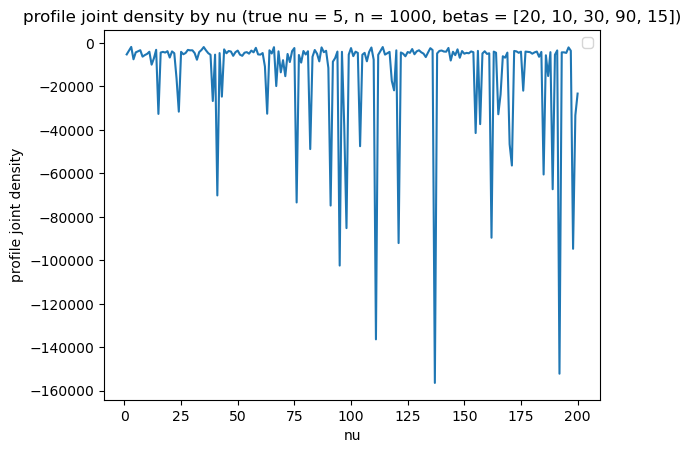

3


       message: Maximum number of function evaluations has been exceeded.
       success: False
        status: 1
           fun: 1829.7995728005726
             x: [ 4.875e+00]
           nit: 74
          nfev: 200
 final_simplex: (array([[ 4.875e+00],
                       [ 4.875e+00]]), array([ 1.830e+03,  4.978e+03]))

In [101]:
# Generate Data
p = 5
beta = np.array([20, 10, 30, 90, 15])
n = 1000
nu_origin = 5
sigma_sqr = 1.5
corr = generate_Corr_identity(p)  # You need to define this function
y, X = generate_data(n, p, sigma_sqr, beta, nu_origin, corr)

# Profile posterior Grid search
nu_list =[]
profile_post_list = []

for nu in range(1,201):
    nu_list.append(nu)
    profile_post_list.append(logJeff(nu) - profile_loglikelihood(nu)) # Note: profile_loglikelihood returns negative eqt
    profile_post_df = pd.DataFrame({'nu': nu_list,
                        'profile_post_list': profile_post_list,
                        })
    
# Profile posterior Plotting
plt.plot(profile_post_df['nu'], profile_post_df['profile_post_list'])
# Adding labels and legend
plt.xlabel('nu')
plt.ylabel('profile joint density')
plt.title('profile joint density by nu (true nu = 5, n = 1000, betas = [20, 10, 30, 90, 15])')
plt.legend()
# Showing the plot
plt.show()

# MAP grid search
print(np.argmax(profile_post_df['profile_post_list'])+1)

# MAP optimized
minimize(negative_log_profile_joint,nu_origin,method='Nelder-Mead', bounds = [(0, np.inf)])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


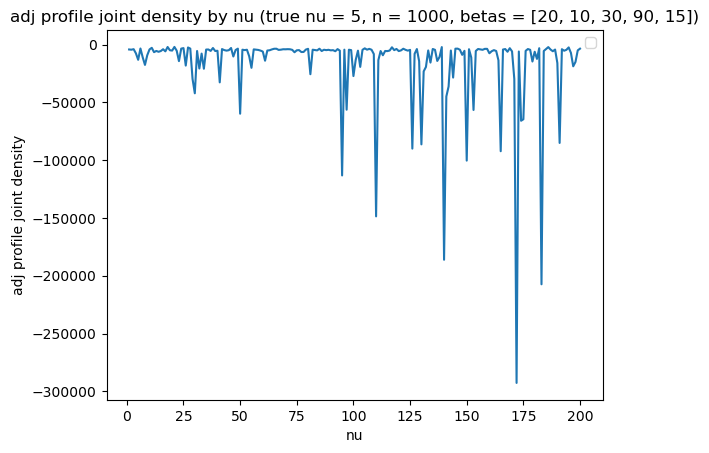

21


       message: Maximum number of function evaluations has been exceeded.
       success: False
        status: 1
           fun: 1849.084146875819
             x: [ 4.625e+00]
           nit: 74
          nfev: 200
 final_simplex: (array([[ 4.625e+00],
                       [ 4.625e+00]]), array([ 1.849e+03,  4.212e+03]))

In [102]:
# Profile posterior Grid search
nu_list =[]
adj_profile_post_list = []

for nu in range(1,201):
    nu_list.append(nu)
    adj_profile_post_list.append(logJeff(nu) - adj_profile_loglikelihood(nu)) # Note: profile_loglikelihood returns negative eqt
    adj_profile_post_df = pd.DataFrame({'nu': nu_list,
                        'adj_profile_loglikelihood': adj_profile_post_list,
                        })
    
# Profile posterior Plotting
plt.plot(adj_profile_post_df['nu'], adj_profile_post_df['adj_profile_loglikelihood'])
# Adding labels and legend
plt.xlabel('nu')
plt.ylabel('adj profile joint density')
plt.title('adj profile joint density by nu (true nu = 5, n = 1000, betas = [20, 10, 30, 90, 15])')
plt.legend()
# Showing the plot
plt.show()

# adj MAP grid search
print(np.argmax(adj_profile_post_df['adj_profile_loglikelihood'])+1)

# adj MAP optimized
minimize(negative_log_adj_joint,nu_origin,method='Nelder-Mead', bounds = [(0, np.inf)])

## true nu = 100, betas = [20, 10, 30, 90, 15]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


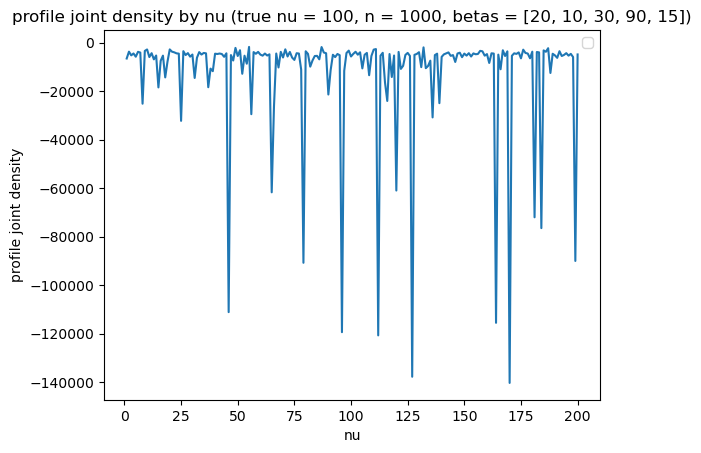

55


       message: Maximum number of function evaluations has been exceeded.
       success: False
        status: 1
           fun: 1618.5444905333338
             x: [ 8.500e+01]
           nit: 76
          nfev: 200
 final_simplex: (array([[ 8.500e+01],
                       [ 8.500e+01]]), array([ 1.619e+03,  5.414e+03]))

In [103]:
# Generate Data
p = 5
beta = np.array([20, 10, 30, 90, 15])
n = 1000
nu_origin = 100
sigma_sqr = 1.5
corr = generate_Corr_identity(p)  # You need to define this function
y, X = generate_data(n, p, sigma_sqr, beta, nu_origin, corr)

# Profile posterior Grid search
nu_list =[]
profile_post_list = []

for nu in range(1,201):
    nu_list.append(nu)
    profile_post_list.append(logJeff(nu) - profile_loglikelihood(nu)) # Note: profile_loglikelihood returns negative eqt
    profile_post_df = pd.DataFrame({'nu': nu_list,
                        'profile_post_list': profile_post_list,
                        })
    
# Profile posterior Plotting
plt.plot(profile_post_df['nu'], profile_post_df['profile_post_list'])
# Adding labels and legend
plt.xlabel('nu')
plt.ylabel('profile joint density')
plt.title('profile joint density by nu (true nu = 100, n = 1000, betas = [20, 10, 30, 90, 15])')
plt.legend()
# Showing the plot
plt.show()

# MAP grid search
print(np.argmax(profile_post_df['profile_post_list'])+1)

# MAP optimized
minimize(negative_log_profile_joint,nu_origin,method='Nelder-Mead', bounds = [(0, np.inf)])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


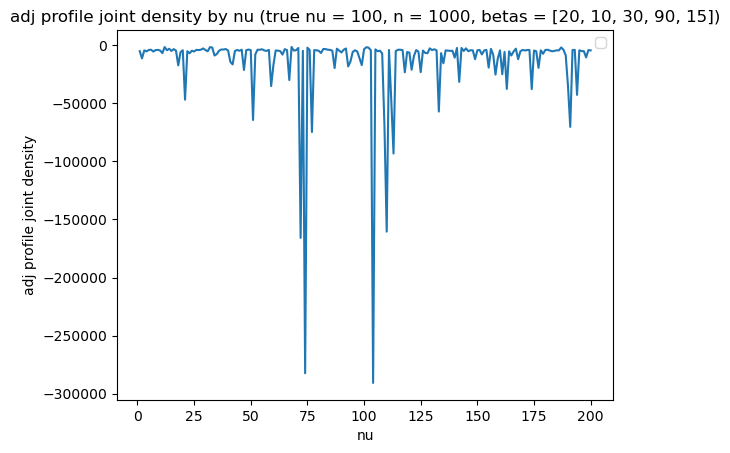

68


       message: Maximum number of function evaluations has been exceeded.
       success: False
        status: 1
           fun: 1640.900023645613
             x: [ 1.015e+02]
           nit: 76
          nfev: 200
 final_simplex: (array([[ 1.015e+02],
                       [ 1.015e+02]]), array([ 1.641e+03,  5.341e+03]))

In [104]:
# Profile posterior Grid search
nu_list =[]
adj_profile_post_list = []

for nu in range(1,201):
    nu_list.append(nu)
    adj_profile_post_list.append(logJeff(nu) - adj_profile_loglikelihood(nu)) # Note: profile_loglikelihood returns negative eqt
    adj_profile_post_df = pd.DataFrame({'nu': nu_list,
                        'adj_profile_loglikelihood': adj_profile_post_list,
                        })
    
# Profile posterior Plotting
plt.plot(adj_profile_post_df['nu'], adj_profile_post_df['adj_profile_loglikelihood'])
# Adding labels and legend
plt.xlabel('nu')
plt.ylabel('adj profile joint density')
plt.title('adj profile joint density by nu (true nu = 100, n = 1000, betas = [20, 10, 30, 90, 15])')
plt.legend()
# Showing the plot
plt.show()

# adj MAP grid search
print(np.argmax(adj_profile_post_df['adj_profile_loglikelihood'])+1)

# adj MAP optimized
minimize(negative_log_adj_joint,nu_origin,method='Nelder-Mead', bounds = [(0, np.inf)])

## MSE plot (optimize)

In [99]:
# Fix number of observations
n = 100

result_value_map_profile = []
result_value_map_adj_profile =[] 
nu_list = []

for nu_origin in range(1,11): # loop true nu 
    nu_list.append(nu_origin)
    map_profile =[]
    map_adj_profile =[]

    for j in range(10): # number of simulations
        p = 5
        beta = np.array([2, 1, 0.3, 0.9, 1]) #stats.norm.rvs(size=p)
        sigma_sqr = 1.5
        corr = generate_Corr_identity(p)  
        y, X = generate_data(n, p, sigma_sqr, beta, nu_origin, corr) ## Generate data
     
        # profile MAP for one simulation
        profile_result = minimize(negative_log_profile_joint,nu_origin,method='Nelder-Mead', bounds = [(0, np.inf)])
        if profile_result.success == False:
            print("profile joint error: " + 'true nu = '+str(nu_origin) +' at ' + str(j + 1) + 'th simulation')
        else:
            map_profile.append(profile_result.x)
        # adj profile MAP for one simulation
        adj_profile_result = minimize(negative_log_adj_joint,nu_origin,method='Nelder-Mead', bounds = [(0, np.inf)])
        if adj_profile_result.success == False:
            print("adj profile joint error: " + 'true nu = '+str(nu_origin) +' at ' + str(j + 1) + 'th simulation')
        else:
            map_adj_profile.append(adj_profile_result.x)
    
    # record averaged MSE 
    value_map_profile = calculate_y_axix(nu_origin, map_profile)
    result_value_map_profile.append(value_map_profile) 
    
    value_map_adj_profile = calculate_y_axix(nu_origin, map_adj_profile)
    result_value_map_adj_profile.append(value_map_adj_profile)     
    

df = pd.DataFrame({'nu': nu_list,
                    'MSE profile joint': result_value_map_profile,
                   'MSE adj profile joint': result_value_map_adj_profile
                   
                        })

adj profile joint error: true nu = 1 at 2th simulation
adj profile joint error: true nu = 1 at 5th simulation
adj profile joint error: true nu = 1 at 6th simulation
adj profile joint error: true nu = 1 at 8th simulation
adj profile joint error: true nu = 1 at 9th simulation
adj profile joint error: true nu = 2 at 3th simulation
adj profile joint error: true nu = 2 at 7th simulation
adj profile joint error: true nu = 3 at 4th simulation
adj profile joint error: true nu = 3 at 6th simulation
adj profile joint error: true nu = 3 at 7th simulation
adj profile joint error: true nu = 3 at 10th simulation
adj profile joint error: true nu = 4 at 1th simulation
adj profile joint error: true nu = 4 at 7th simulation
adj profile joint error: true nu = 4 at 8th simulation
adj profile joint error: true nu = 4 at 9th simulation
adj profile joint error: true nu = 5 at 2th simulation
adj profile joint error: true nu = 5 at 3th simulation
adj profile joint error: true nu = 5 at 5th simulation


/tmp/ipykernel_53/541403973.py:3: RuntimeWarning: divide by zero encountered in divide
  return np.log((x/(x+3))**(1/2)*(special.polygamma(1,x/2) - special.polygamma(1, (x+1)/2) - 2*(x+3)/(x*(x+1)**2))**(1/2))
/tmp/ipykernel_53/541403973.py:3: RuntimeWarning: invalid value encountered in subtract
  return np.log((x/(x+3))**(1/2)*(special.polygamma(1,x/2) - special.polygamma(1, (x+1)/2) - 2*(x+3)/(x*(x+1)**2))**(1/2))
/tmp/ipykernel_53/919142380.py:38: RuntimeWarning: divide by zero encountered in log
  equation = n * np.log(special.gamma((nu + 1)/2)) + n* nu *0.5 * np.log(nu) - n * np.log(special.gamma(nu/2)) - 0.5*n*np.log(np.pi) - n * np.log(sigma) - 0.5 *(nu + 1)*np.sum(np.log(nu + ((y - XB)/sigma)**2))
/tmp/ipykernel_53/919142380.py:38: RuntimeWarning: invalid value encountered in multiply
  equation = n * np.log(special.gamma((nu + 1)/2)) + n* nu *0.5 * np.log(nu) - n * np.log(special.gamma(nu/2)) - 0.5*n*np.log(np.pi) - n * np.log(sigma) - 0.5 *(nu + 1)*np.sum(np.log(nu + ((y - X

adj profile joint error: true nu = 6 at 3th simulation
adj profile joint error: true nu = 6 at 4th simulation
adj profile joint error: true nu = 7 at 2th simulation
adj profile joint error: true nu = 7 at 4th simulation
adj profile joint error: true nu = 7 at 6th simulation
adj profile joint error: true nu = 8 at 1th simulation
adj profile joint error: true nu = 8 at 5th simulation
adj profile joint error: true nu = 8 at 6th simulation
adj profile joint error: true nu = 8 at 9th simulation
adj profile joint error: true nu = 9 at 1th simulation
adj profile joint error: true nu = 9 at 2th simulation
adj profile joint error: true nu = 9 at 4th simulation
adj profile joint error: true nu = 9 at 6th simulation
adj profile joint error: true nu = 9 at 7th simulation
adj profile joint error: true nu = 9 at 10th simulation
adj profile joint error: true nu = 10 at 3th simulation
adj profile joint error: true nu = 10 at 4th simulation
adj profile joint error: true nu = 10 at 7th simulation
adj pr

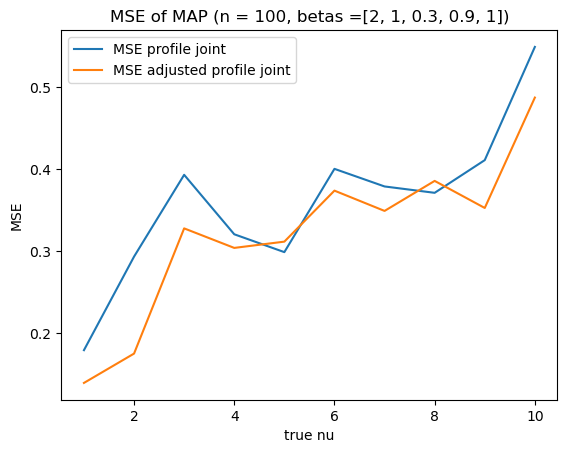

In [100]:
# Plot profile MAP(grid search) vs nu 

# Plotting
plt.plot(df['nu'], df['MSE profile joint'], label='MSE profile joint')
plt.plot(df['nu'], df['MSE adj profile joint'], label='MSE adjusted profile joint')
# Adding labels and legend
plt.xlabel('true nu')
plt.ylabel('MSE')
plt.title('MSE of MAP (n = 100, betas =[2, 1, 0.3, 0.9, 1])') 
plt.legend()
# Showing the plot
plt.show()

## MSE plot (grid search)

In [95]:
# Fix number of observations
n = 100

result_value_map_profile = []
result_value_map_adj_profile =[] 
nu_list = []

for nu_origin in range(1,11): # loop true nu 
    nu_list.append(nu_origin)
    map_profile =[]
    map_adj_profile =[]

    for j in range(10): # number of simulations
        p = 5
        beta = np.array([2, 1, 0.3, 0.9, 1]) #stats.norm.rvs(size=p)
        sigma_sqr = 1.5
        corr = generate_Corr_identity(p)  
        y, X = generate_data(n, p, sigma_sqr, beta, nu_origin, corr) ## Generate data
        
        # Profile posterior Grid search MAP
        profile_post_list = []
        adj_profile_post_list = []

        for nu in range(1,21):
            profile_post_list.append(logJeff(nu) - profile_loglikelihood(nu)) # Note: profile_loglikelihood returns negative eqt
            profile_post_df = pd.DataFrame({'profile_post_list': profile_post_list}) 
            adj_profile_post_list.append(logJeff(nu) - adj_profile_loglikelihood(nu)) # Note: profile_loglikelihood returns negative eqt
            adj_profile_post_df = pd.DataFrame({'adj_profile_loglikelihood': adj_profile_post_list})
     
        # profile MAP for one simulation
        profile_result = np.argmax(profile_post_df['profile_post_list']) + 1
        map_profile.append(profile_result)
        # adj profile MAP for one simulation
        adj_profile_result = np.argmax(adj_profile_post_df['adj_profile_loglikelihood']) + 1
        map_adj_profile.append(adj_profile_result)

    # record averaged MSE 
    value_map_profile = calculate_y_axix(nu_origin, map_profile)
    result_value_map_profile.append(value_map_profile) 
    
    value_map_adj_profile = calculate_y_axix(nu_origin, map_adj_profile)
    result_value_map_adj_profile.append(value_map_adj_profile)     
    

df = pd.DataFrame({'nu': nu_list,
                    'MSE profile joint': result_value_map_profile,
                   'MSE adj profile joint': result_value_map_adj_profile
                   
                        })

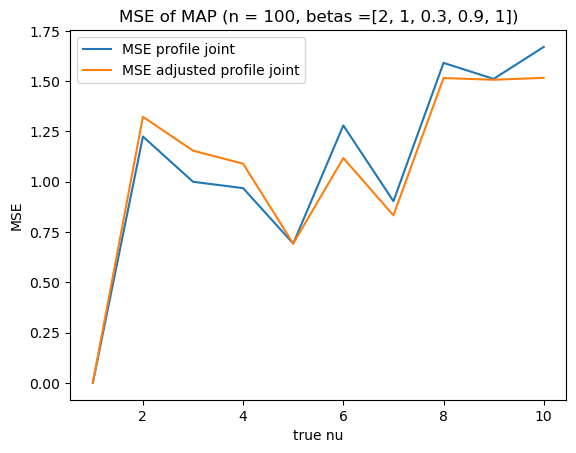

In [98]:
# Plot profile MAP(grid search) vs nu 

# Plotting
plt.plot(df['nu'], df['MSE profile joint'], label='MSE profile joint')
plt.plot(df['nu'], df['MSE adj profile joint'], label='MSE adjusted profile joint')
# Adding labels and legend
plt.xlabel('true nu')
plt.ylabel('MSE')
plt.title('MSE of MAP (n = 100, betas =[2, 1, 0.3, 0.9, 1])') 
plt.legend()
# Showing the plot
plt.show()

# Task 3: high-dim setting MSE plot

- generate the plots using optimizer instead of MCMC to do a cross-check
- note down the computation time in your report for trying with each dimension p
- also meaningful to compare across different methods (e.g., frequentist, Bayesian with different priors, adj+Jeffresy, etc) at different p

In [4]:
def calculate_y_axix(nu_origin, nu_est):
    n = len(nu_est)
    nu_origin_vec = nu_origin * np.ones((n, 1))
    mse = np.sum((nu_est - nu_origin_vec)**2) / n
    result = np.sqrt(mse)/nu_origin
    return result

# Jeffrey's prior
def logJeff(x):
    return np.log((x/(x+3))**(1/2)*(special.polygamma(1,x/2) - special.polygamma(1, (x+1)/2) - 2*(x+3)/(x*(x+1)**2))**(1/2))

# sigma prior
def logsig(x):
    return -np.log(x)

def logJeff_pymc(x):
    return pt.log((x/(x+3))**(1/2)*(pt.polygamma(1,x/2) - pt.polygamma(1, (x+1)/2) - 2*(x+3)/(x*(x+1)**2))**(1/2))

In [10]:
# Fix number of observations
n = 30
nu_origin = 5 

result_value_map_profile = []
result_value_map_adj_profile =[] 
result_value_median_Jeff = []

dim_list = []

# Generate data for different dim       
for dim in range(1, 30, 1): ## loop for high dim predictors 
    dim_list.append(dim)
    p = dim
    beta = stats.norm.rvs(size=p)
    sigma_sqr = 1.5
    map_profile =[]
    map_adj_profile =[]
    est_nu_jeff = []

    for j in range(5): # number of simulations
        corr = generate_Corr_identity(p)  
        y, X = generate_data(n, p, sigma_sqr, beta, nu_origin, corr) ## Generate data

        # Grid search
        # Profile posterior Grid search MAP --- store all values for each simulation
        profile_post_list = []
        adj_profile_post_list = []
        
        for nu in range(1,11):
            profile_post_list.append(logJeff(nu) - profile_loglikelihood(nu)) # Note: profile_loglikelihood returns negative eqt
            profile_post_df = pd.DataFrame({'profile_post_list': profile_post_list}) 
            adj_profile_post_list.append(logJeff(nu) - adj_profile_loglikelihood(nu)) # Note: adj_profile_loglikelihood returns negative eqt
            adj_profile_post_df = pd.DataFrame({'adj_profile_loglikelihood': adj_profile_post_list})
     
        # profile MAP for one simulation
        profile_result = np.argmax(profile_post_df['profile_post_list']) + 1
        map_profile.append(profile_result)
        # adj profile MAP for one simulation
        adj_profile_result = np.argmax(adj_profile_post_df['adj_profile_loglikelihood']) + 1
        map_adj_profile.append(adj_profile_result)
        
        # Bayesian model 
        with pm.Model() as modelJeff_high_dim: ## Jeff model
            nu = pm.CustomDist('nu', logp=logJeff_pymc, initval = 1)
            sigma = pm.CustomDist('sigma',logp=logsig, initval = 1)
            betas = pm.Flat('betas', shape = (p,1))
            y = pm.StudentT('y', nu = nu, mu = pm.math.dot(X, betas), sigma = sigma, shape = (n,1), observed = y)
            idataJeff_high_dim = pm.sample() 
            est_nu = np.median(idataJeff_high_dim.posterior['nu']) ## Posterior median for a simulation
            est_nu_jeff.append(est_nu) ## Store all posterior medians of same dim in a list

    # record averaged MSE 
    value_map_profile = calculate_y_axix(nu_origin, map_profile)
    result_value_map_profile.append(value_map_profile) 
    
    value_map_adj_profile = calculate_y_axix(nu_origin, map_adj_profile)
    result_value_map_adj_profile.append(value_map_adj_profile) 
    
    value_mse_Jeff = calculate_y_axix(nu_origin, est_nu_jeff)
    result_value_median_Jeff.append(value_mse_Jeff) ## Store MSE for each dim in a list

df = pd.DataFrame({'dim': dim_list,
                    'MSE profile joint': result_value_map_profile,
                   'MSE adj profile joint': result_value_map_adj_profile,
                   'MSE Jeffrey post median': result_value_median_Jeff   
                        })

/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, sigma, betas]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 986 divergences after tuning. Increase `target_accept` or reparameterize.
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/conda/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op polygamma does not pro

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 990 divergences after tuning. Increase `target_accept` or reparameterize.


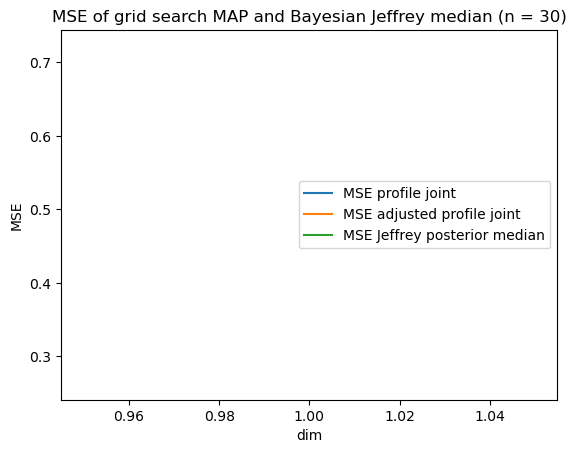

In [11]:
# Plot profile MAP(grid search) vs nu 

# Plotting
plt.plot(df['dim'], df['MSE profile joint'], label='MSE profile joint')
plt.plot(df['dim'], df['MSE adj profile joint'], label='MSE adjusted profile joint')
plt.plot(df['dim'], df['MSE Jeffrey post median'], label='MSE Jeffrey posterior median')
# Adding labels and legend
plt.xlabel('dim')
plt.ylabel('MSE')
plt.title('MSE of grid search MAP and Bayesian Jeffrey median (n = 30)') 
plt.legend()
# Showing the plot
plt.show()